In [1]:
import numpy as np
import pandas as pd

In [2]:
# 书中加载MNIST数据的模块fetch_mldata已作废，详情见下面的链接
# https://github.com/ageron/handson-ml/issues/301
# 20200312 以下是新的解决方案
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'DESCR': "**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered i

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

In [8]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

<IPython.core.display.Javascript object>


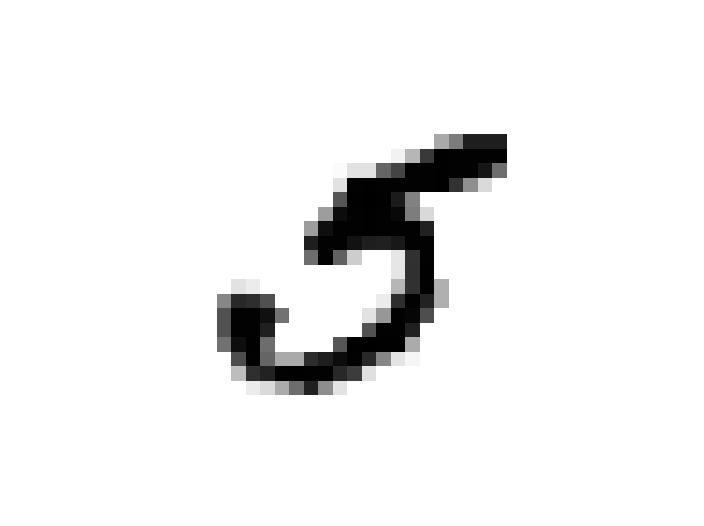

In [9]:
plt.imshow(some_digit_image, 
           cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [10]:
y[36000]

5

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 训练一个二分类器

In [13]:
y_train_5 = (y_train  == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
 sgd_clf.predict([some_digit])

array([False])

## 对性能的评估

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

F:\my_work\day_20200229\venv\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9642
0.9377
0.96565


In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9642 , 0.9377 , 0.96565])

In [21]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9094 , 0.907  , 0.91255])

### 混淆矩阵

In [23]:
from sklearn.model_selection import cross_val_predict

In [24]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
confusion_matrix(y_train_5, y_train_pred)

array([[52959,  1620],
       [ 1029,  4392]], dtype=int64)

### 准确率与召回率

In [27]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [60000, 20000]

In [29]:
recall_score(y_train_5, y_train_pred)

0.8101826231322634

In [30]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_train_5, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [60000, 20000]

### 准确率/召回率之间的折衷

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-1621.54899066])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [34]:
y_some_digit_pred

array([False])

In [35]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<IPython.core.display.Javascript object>


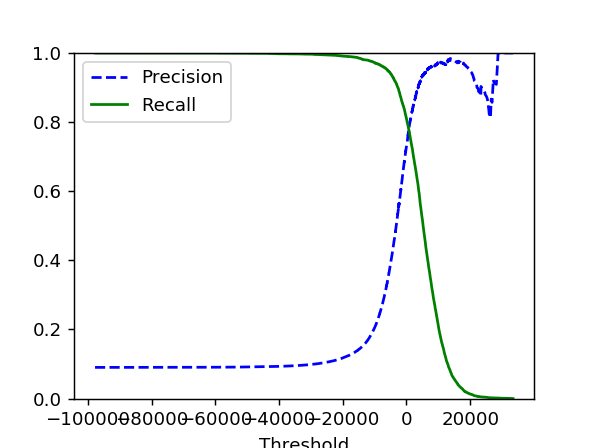

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [39]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

F:\my_work\day_20200229\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.0

## ROC 曲线

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

<IPython.core.display.Javascript object>


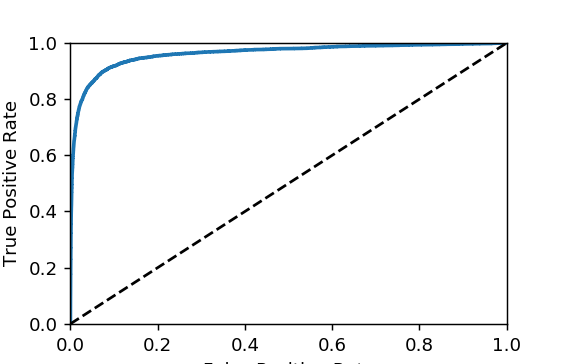

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9621020838893789

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [45]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

<IPython.core.display.Javascript object>


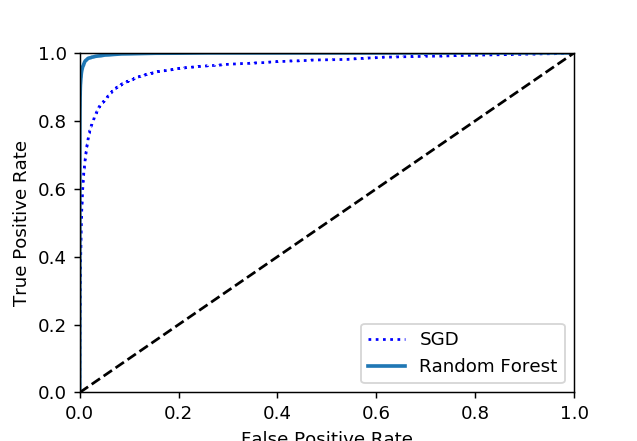

In [46]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="best")
plt.show()

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985122523564259

## 多类分类

In [48]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [49]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -6408.12376972, -20878.61006028,  -8833.82340177,
         -3155.82408791, -18418.5486186 ,   2393.63868665,
        -17649.19428995, -17868.99519043, -11744.26183054,
        -18473.27521834]])

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [52]:
sgd_clf.classes_[5]

5

In [53]:
from sklearn.multiclass import OneVsOneClassifier

In [54]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [55]:
len(ovo_clf.estimators_)

45

In [56]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [58]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.  , 0.  , 0.04, 0.  , 0.92, 0.  , 0.02, 0.01, 0.  ]])

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85535, 0.8719 , 0.8644 ])

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

F:\my_work\day_20200229\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.8975, 0.9004, 0.9019])

## 误差分析

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

F:\my_work\day_20200229\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5593,    0,   20,    4,    9,   37,   31,    5,  223,    1],
       [   0, 6408,   42,   22,    3,   42,    4,    8,  202,   11],
       [  23,   24, 5260,   82,   73,   26,   65,   37,  358,   10],
       [  25,   22,  113, 5225,    1,  211,   24,   40,  402,   68],
       [  11,   14,   38,   13, 5246,   11,   35,   15,  316,  143],
       [  23,   19,   33,  152,   55, 4460,   77,   17,  527,   58],
       [  31,   16,   54,    1,   40,   89, 5543,    8,  136,    0],
       [  19,   13,   50,   28,   43,   12,    6, 5715,  176,  203],
       [  16,   62,   40,   98,    4,  122,   29,    8, 5431,   41],
       [  22,   23,   28,   58,  123,   33,    1,  170,  376, 5115]],
      dtype=int64)

<IPython.core.display.Javascript object>


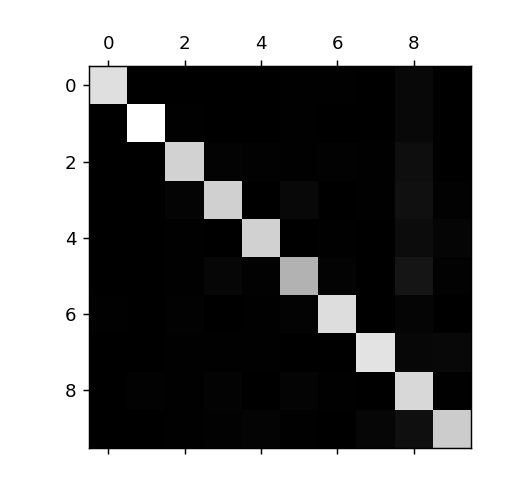

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

<IPython.core.display.Javascript object>


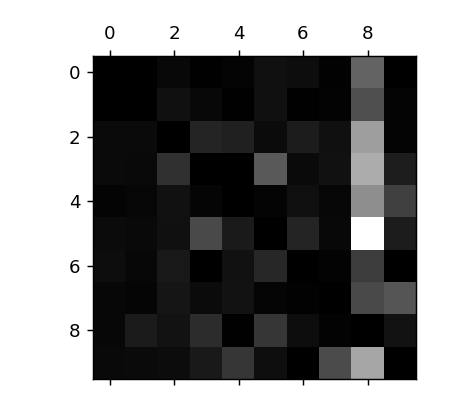

In [64]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [66]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

<IPython.core.display.Javascript object>


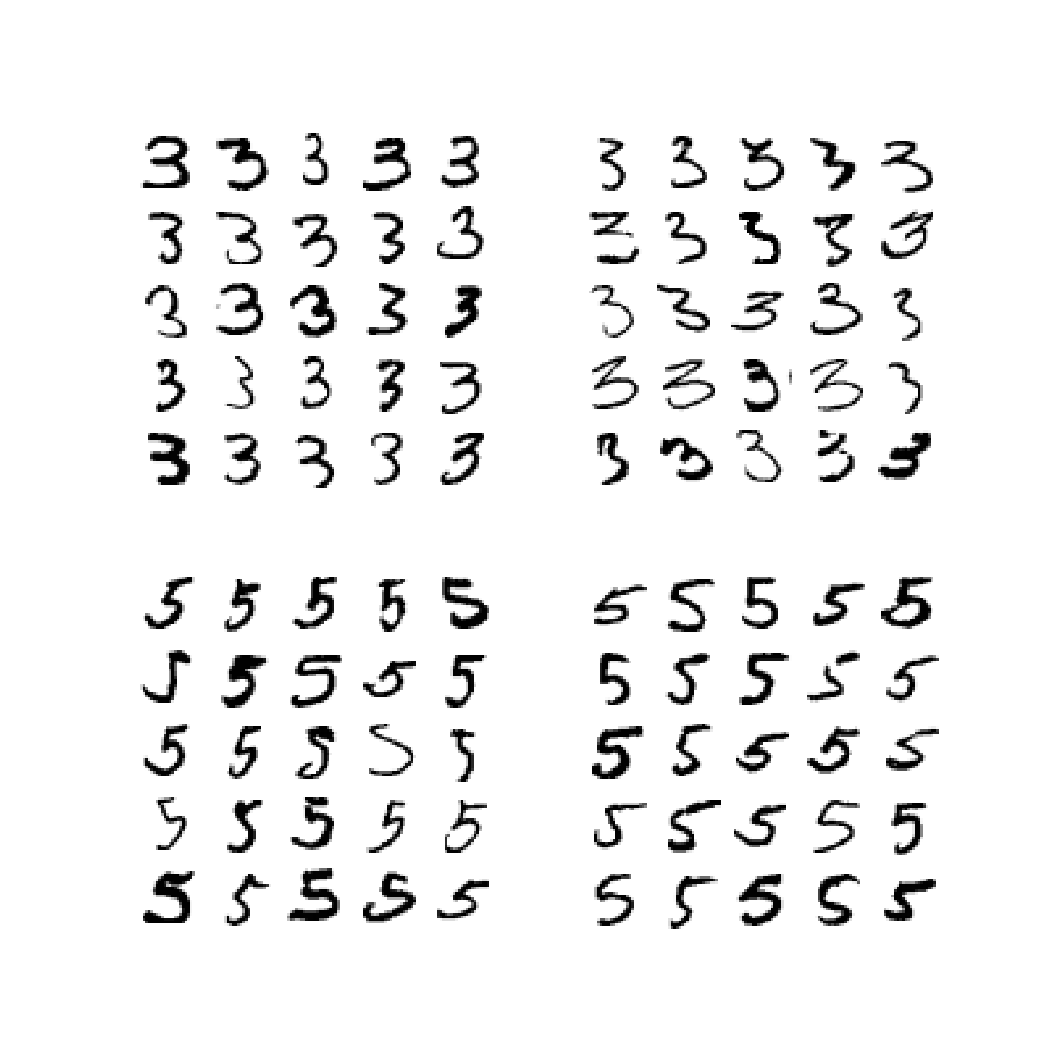

In [80]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 多标签分类

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [69]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [70]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [72]:
f1_score(y_train, y_train_knn_pred, average="macro")

0.9683533403446807

## 多输出分类

In [74]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [81]:
def plot_digit(data):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

<IPython.core.display.Javascript object>


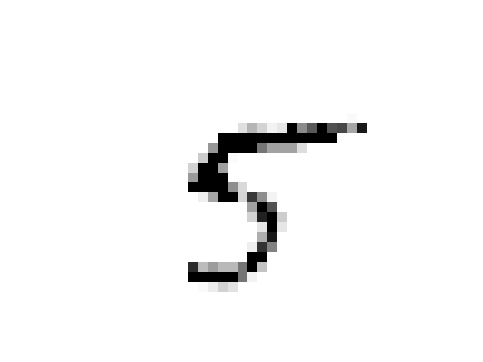

In [82]:
some_index = 5500

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)